#### Stroke Prediction : Capstone Project, Udacity Data Science Nanodegree 

## Table of Contents
* [Introduction](#int)
* [Data Understanding](#load)
    * [Exploratory Data Analysis](#eda)
* [Data Prep](#prep)
    * [Feature Extraction](#fext)
    * [Train test Split](#ttsplit)
* [Modeling](#model)
* [Conclusions](#conclude)

## Introduction
<a class="anchor" id="int"></a>

According to WHO (World Health Organization), Stroke is the second leading cause of death globally, being responsible for about 11% of the total deaths.

In this project I will be loading and manipulating a patients dataset with pandas and sklearn to engineer relevant features for predicting stroke. The Stroke prediction data contains information about a set of 5110 patients,  collecting basic health details, measures and their lifestyle choices. This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient. 

We will be comparing few machine learning models and then choosing the best machine learning model that predict the chances of Stroke in the patients. 

In [33]:
# import libraries
import time
import pandas as pd
import numpy as np
import seaborn  as sns
import sklearn

from IPython.display import display 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline


## Data Understanding
<a class="anchor" id="load"></a>
Our dataset file is `healthcare_dataset_stroke_data.csv`. First the dataset must be loaded, cleaned, evaluated and Preped. For e.g., checking for invalid or missing data - for example, records without key features like Age, Hypertension, Average glucose level, BMI etc.

In [34]:
# read csv file and look at the data 
df = pd.read_csv("healthcare_dataset_stroke_data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [35]:
# Let's look at how pandas infered the schema of the orginal dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [36]:
# Let's get the counts of Nulls in all the columns
df.isnull().value_counts()

id     gender  age    hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level  bmi    smoking_status  stroke
False  False   False  False         False          False         False      False           False              False  False           False     4909
                                                                                                               True   False           False      201
dtype: int64

In [37]:
# Looks like 'bmi' is the only column with Null values in it.
df[df['bmi'].isna()]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


 Below are our initial observations:
     
     1) There are 5110 rows and 12 columns which is of a decent size, and except 'bmi' all other columns are with no nulls
     2) Stroke is the prediction target for our model. It takes two values: 1 if the participant had a stroke and 0 if the participant didn’t. 
     3) Stroke column is a numeric type , that means we dont have to convert it. 
     4) "Unknown" in smoking_status means that the information is unavailable for this patient

In [38]:
#Lets double check if we are correct about 'bmi' being the only column with Nulls in it.
df[df['bmi'].isnull()].isna().value_counts()

id     gender  age    hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level  bmi   smoking_status  stroke
False  False   False  False         False          False         False      False           False              True  False           False     201
dtype: int64

In [39]:
# Confirming the total number of NaN values in the bmi column
df['bmi'].isnull().sum()

201

> We have 201 NaN values for the BMI column, which is nearly less than 4% of the total records.

> Since BMI is one of the key features in our dataset, I would rather impute values than delete those records with missing values.

> To impute values I will be using the Forward Fill, Back Fill methods to populate values in the BMI column, after the DF is sorted by Gender and Age, and grouped by Gender.

In [40]:
#Imputing the missing values in the BMI column, using ffill, bfill methods and then checking the NaN value counts in the df
df['bmi'] = df.sort_values(by=['gender','age']).groupby('gender')['bmi'].fillna(method='ffill').fillna(method='bfill')
df.isna().value_counts()

id     gender  age    hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level  bmi    smoking_status  stroke
False  False   False  False         False          False         False      False           False              False  False           False     5110
dtype: int64

> We do not have any NaN values in any of the columns in our DF now.

In [41]:
# Let's make all the column names case normalized for consistency sake
df.columns = df.columns.str.lower()

In [42]:
# look at the new column names to ensure the names are all case normalized
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

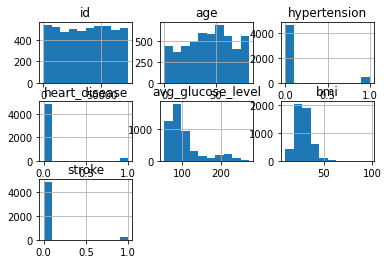

In [43]:
# let's look at the distribution of numerical columns of our dataframe
df.hist();

> The age column has a good distribution of patients ranging from 8 months to 82 years. The number patients with heart disease is < 300, number of patients with hypertesnion is less than 500 and number of patients with a previous history of Stroke is 
less than 250. 

> The Average Glucose level column has mixed distribution, with majority of the patients having less than 200 Avg_Glucose_Levels

In [44]:
# The columns (hypertension and heart_disease) show as integer datatype (1,0) , lets convert them into an object datatype
df["hypertension"]=df["hypertension"].astype("object")
df["heart_disease"]=df["heart_disease"].astype("object")

In [45]:
#Lets check the schema of the updated dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 479.2+ KB


> This now gives us two more additional categorical eatures in our dataset, viz. Hypertension and Heart_Disease

##### Exploratory data analysis
<a class="anchor" id="eda"></a>
Looking forward to at the data in a ML modelling perspective and understanding it beforehand, is crucial step in building a succesfull machine learning model.
We should always look for missing values, distribution of values in target variable, number of unique categorical values etc.

> Look for any additional null handling needs in the dataset

In [46]:
# Check for null values in our df
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

> We do not have any null values to handle

> Let us look at the distribution and description of the few key column's values.

In [47]:
df.heart_disease.value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [48]:
df.age.describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [49]:
df.avg_glucose_level.describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [50]:
df.hypertension.value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [51]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

> Let us also look at the cardinality of the categorical features' values.

In [52]:
# print the number of unique values in each of the categorical column
df.select_dtypes(include="object").nunique()

gender            3
hypertension      2
heart_disease     2
ever_married      2
work_type         5
residence_type    2
smoking_status    4
dtype: int64

> The categorical columns have low cardinality which is good news. That means we do not have to perform any additional handling of the values as of now.

> Let's check the distribution of target values

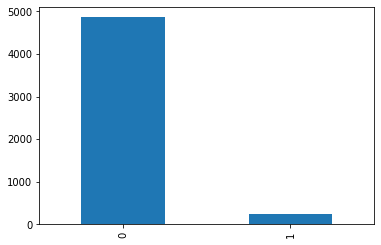

In [53]:
# Lets first plot the distribution and get a visual
df.stroke.value_counts().plot(kind='bar');

In [54]:
# The distribution is imbalanced, let's get the exact counts for the distribution
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

> The dataset is an imbalanced dataset since the number of patients with prior history of Stroke (nearly 250) is way less than the patients that do not have a prior history of Stroke (less than 4900)

In [55]:
# check for the overall Stroke rate
stroke_avg=df["stroke"].mean()
stroke_avg*100

4.87279843444227

> The Stroke rate for the patient population in our dataset is around 4.8%

> Lets calculate the Risk Ratio for all of the categorical features to check for Stroke risk across all groups in those features

In [56]:
# create a list of variables whose data type is object and assign it to a categorical variable 
cat_var=list(df.select_dtypes(include="object").columns)

In [57]:
# lets display the risk rate for all the groups in the cat_var list
for col in cat_var:
    df_group = df.groupby(col)["stroke"].agg(["mean"])
    df_group["rate"] = df_group["mean"]/stroke_avg
    display(df_group)
    

,mean,rate
gender,,
Female,0.047094,0.966471
Male,0.051064,1.047936
Other,0.000000,0.000000


,mean,rate
hypertension,,
0,0.039679,0.814298
1,0.132530,2.719795


,mean,rate
heart_disease,,
0,0.041787,0.857563
1,0.170290,3.494703


,mean,rate
ever_married,,
No,0.016505,0.338725
Yes,0.065613,1.346513


,mean,rate
work_type,,
Govt_job,0.050228,1.030790
Never_worked,0.000000,0.000000
Private,0.050940,1.045399
Self-employed,0.079365,1.628737
children,0.002911,0.059744


,mean,rate
residence_type,,
Rural,0.045346,0.930596
Urban,0.052003,1.067212


,mean,rate
smoking_status,,
Unknown,0.030440,0.624701
formerly smoked,0.079096,1.623216
never smoked,0.047569,0.976209
smokes,0.053232,1.092431


> from the above results we can infer that Patients who are/were married, are male, who live in Urban areas, have smoked in past and/or present, who work (irrespective of the type viz. private, govt or self employed), who have prior history of Hypertension and Heart disease are at higher risk of Stroke (rate > 1.0).

Let's now find out the most useful categorical features

In [58]:
# write a function to calculate mutual info score using the mutual _info_score function from Scikit-learn
def calc_mutual_info(series):
    """
    Retuns Mutual information, a non-negative value, measured in nats using the natural logarithm.
    Param: feature names in the form of series for comparison
    Retuns Mutual info score of each categorical features against our target variable Stroke.
    """                                      
    return mutual_info_score(series, df["stroke"])     

# apply the newly created calc_mutual_info on each categorical feature of the data frame 
mutual_info = df[cat_var].apply(calc_mutual_info) 
mutual_info.sort_values()

gender            0.000051
residence_type    0.000120
smoking_status    0.002750
heart_disease     0.005897
hypertension      0.005976
work_type         0.006825
ever_married      0.006950
dtype: float64

> Of all the categorical features , except gender, residence_type, smoking_status (which are the least useful features) rest all are more useful features for our model. where the most useful amongst them all seems to be work_type and ever_married.

Now let's look at how the numerical features are corelated with Stroke

<AxesSubplot:>

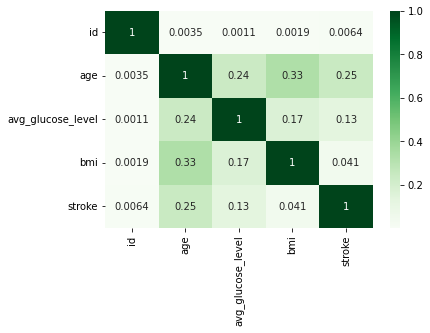

In [59]:
corr=df.corr()
sns.heatmap(corr,cmap="Greens",annot=True)

> Age, Avg_Glucose_Level and BMI all have a positive corelation with Stroke; as the values for these features go up the Stroke rate goes up.

## Data Prep
<a class="anchor" id="prep"></a>
After having a look at the data and finding out what can be useful for the model. Now we have a clear understanding on how other variables affect the target variable - Stroke. 

We now need to perform data prep steps; transforming all categorical variables to numeric features to prepare the data for ML model. 

#### Feature Extraction
<a class="anchor" id="fext"></a>

> ##### One-Hot Encoding
> One hot encoding is one method of converting data to prepare it for an algorithm and get a better prediction. With one-hot, we can convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector. All the values are zero, and the index is marked with a 1.

In [60]:
# Now let's apply One Hot Encoding technique and get new categorical feature columns
df_upd = pd.get_dummies(df, columns=['work_type', 'smoking_status', 'gender'])
df_upd.drop(columns=['id'], inplace=True)

df_upd.replace(to_replace="Urban", value=1, inplace=True)
df_upd.replace(to_replace="Rural", value=0, inplace=True)

df_upd.replace(to_replace="Yes", value=1, inplace=True)
df_upd.replace(to_replace="No", value=0, inplace=True)
df_upd.head()

,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
0,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0,0,1,0
1,61.0,0,0,1,0,202.21,28.4,1,0,0,0,1,0,0,0,1,0,1,0,0
2,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0,0,1,0
3,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1,1,0,0
4,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0,1,0,0


In [61]:
#Checking the structure of the newly formed df
df_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   ever_married                    5110 non-null   int64  
 4   residence_type                  5110 non-null   int64  
 5   avg_glucose_level               5110 non-null   float64
 6   bmi                             5110 non-null   float64
 7   stroke                          5110 non-null   int64  
 8   work_type_Govt_job              5110 non-null   uint8  
 9   work_type_Never_worked          5110 non-null   uint8  
 10  work_type_Private               5110 non-null   uint8  
 11  work_type_Self-employed         5110 non-null   uint8  
 12  work_type_children              51

In [62]:
#Lets see the actual values in our new DF
df_upd.head(3).T

,0,1,2
age,67.00,61.00,80.00
hypertension,0.00,0.00,0.00
heart_disease,1.00,0.00,1.00
ever_married,1.00,1.00,1.00
residence_type,1.00,0.00,0.00
avg_glucose_level,228.69,202.21,105.92
bmi,36.60,28.40,32.50
stroke,1.00,1.00,1.00
work_type_Govt_job,0.00,0.00,0.00
work_type_Never_worked,0.00,0.00,0.00


In [63]:
# Now lets extract the Features and our Prediction Target from our DF, and convert them into a numpy array
stroke_features = ['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'gender_Female',
       'gender_Male', 'gender_Other']

yData = df_upd.stroke.to_numpy()
XData = df_upd[stroke_features].to_numpy()

In [64]:
# Let's now make the data types consistent across the board and check for the shapes of each of datasets.
XData = XData.astype(np.float32)
yData = yData.astype(np.float32)
XData.shape, yData.shape


((5110, 19), (5110,))

In [65]:
#Lets see the actual values in each of the datasets
print(yData)
print(XData)
print(XData[0])

[1. 1. 1. ... 0. 0. 0.]
[[67.  0.  1. ...  0.  1.  0.]
 [61.  0.  0. ...  1.  0.  0.]
 [80.  0.  1. ...  0.  1.  0.]
 ...
 [35.  0.  0. ...  1.  0.  0.]
 [51.  0.  0. ...  0.  1.  0.]
 [44.  0.  0. ...  1.  0.  0.]]
[ 67.     0.     1.     1.     1.   228.69  36.6    0.     0.     1.
   0.     0.     0.     1.     0.     0.     0.     1.     0.  ]


> All the values are now 0's and 1's except for the 3 categorical variables. Age , Avg_Glucose_level and BMI columns haven't changed because they are numerical variables 

##### Split the Data in Train, Validation/Test splits
<a class="anchor" id="ttsplit"></a>


In [66]:
# Using Sklearn train_test_split function to split the updated dataframe into train and val splits at a val size of 30% 
train_X, val_X, train_y, val_y=train_test_split(XData, yData, test_size=0.30, random_state=8)


In [67]:
# checking to see if the val split is at 30% of the XData dataframe
(val_X.shape[0]/XData.shape[0])*100

30.0

In [68]:
# checking the shape of train and test splits
train_X.shape, val_X.shape


((3577, 19), (1533, 19))

In [69]:
# checking the shape of train and test splits
train_y.shape, val_y.shape


((3577,), (1533,))

> now that we have a train and a test split, lets confirm few values in our train and validation sets

In [70]:
# checking values in train_y
train_y

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [71]:
# checking values in val_y
val_y

array([0., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [72]:
# checking values in val_X
val_X[1]

array([51.  ,  0.  ,  0.  ,  1.  ,  1.  , 81.38, 34.1 ,  1.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  1.  ,  0.  ,
        0.  ], dtype=float32)

In [73]:
# checking values in train_X
train_X[1]

array([ 59.  ,   0.  ,   0.  ,   1.  ,   0.  , 211.78,  26.5 ,   0.  ,
         0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         0.  ,   1.  ,   0.  ], dtype=float32)

## Modeling
<a class="anchor" id="model"></a>
After prepping the data by using Scikit-learn to perform one-hot encoding for categotrical variables, and splitting the dataset into Train and Validation, we are now ready to build a ML model with the data.

Since our problem is a binary classification in which we are predicting if a patient is likley to have a Stroke or not, we will put the following classification algorithms to test: 

* Logisitic regression - avoids overfitting, good explainability and efficient to train
* Support Vector Machine - most popular, reliable supervised ML model for Classification problems which also help reduce redundancy.
* Naive Bayes - easy and fast implementation
* KNN (K-Nearest Neighbors) - simple and most widely used for Classification problems in Data science Industry.
* Random Forest Classifier - ensemble method, avoids overfitting and deals well with imbalanced datasets like ours.



In [74]:
# Instantiate all the models in use
lgr = LogisticRegression(solver='lbfgs',random_state=8, max_iter=1000, penalty = 'l2')
rfc = RandomForestClassifier(random_state=1)
nbc = GaussianNB()
knnc = KNeighborsClassifier(10) 
svmc = SVC()

# keep model objects here 
models =[rfc,svmc,knnc,nbc,lgr]

# loop thru all the elements in the models list
for mdl in models:
    print("Model:", mdl)
    start = time.time() #Start time of the Model
    mdl.fit(train_X, train_y) #fit using the train data
    end = time.time() #End time of the Model
    print("Time taken to train (seconds): ", end - start)
    val_predictions = mdl.predict(val_X) #Prediction of Target with the Model
    print("Accuracy: ",metrics.accuracy_score(val_y, val_predictions))
    print("Score: ",mdl.score(train_X, train_y),'\n')   


Model: RandomForestClassifier(random_state=1)
Time taken to train (seconds):  0.8724596500396729
Accuracy:  0.9478147423352903
Score:  1.0 

Model: SVC()
Time taken to train (seconds):  0.30946779251098633
Accuracy:  0.9504240052185258
Score:  0.9516354487000279 

Model: KNeighborsClassifier(n_neighbors=10)
Time taken to train (seconds):  0.004601240158081055
Accuracy:  0.9497716894977168
Score:  0.9516354487000279 

Model: GaussianNB()
Time taken to train (seconds):  0.0069959163665771484
Accuracy:  0.36007827788649704
Score:  0.3707017053396701 

Model: LogisticRegression(max_iter=1000, random_state=8)
Time taken to train (seconds):  1.036616325378418
Accuracy:  0.9497716894977168
Score:  0.9516354487000279 



> Out of the above estimators the Support Vector Machine and Random Forest classifier delivered best results in terms of time taken to complete, Accuracy and scores.

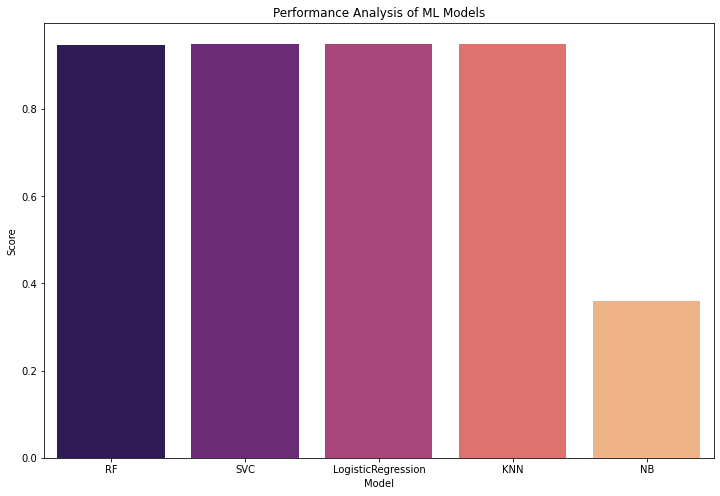

In [75]:
# Lets compare the initial results of the Model Performances we recieved 
model_performance = pd.DataFrame(data={'Model': ['RF','SVC','LogisticRegression','KNN','NB'], 
'Score': [ rfc.score(val_X, val_y), svmc.score(val_X, val_y), lgr.score(val_X, val_y), knnc.score(val_X, val_y), nbc.score(val_X, val_y)]})

plt.figure(figsize=(12, 8))
sns.barplot(x="Model", y="Score", data=model_performance, palette="magma")
plt.title('Performance Analysis of ML Models')
plt.show()

> Again based on the pictorial representation of the scores of the all the above estimators, The Naive-Bayes Classifier recieved the lowest Score. The Support Vector Machine and Random Forest classifier delivered best results in terms of time taken to complete, Accuracy and scores. So lets go with these estimators for further steps, where we tune these models to perform even better.

Model Tuning

In [76]:
# lets see what paramters we can tune for Random Forest Classifier
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

> Looks like we can use n_estimators and max_leaf_nodes parameters here.

In [77]:
# Now lets also see what paramters we can tune for Support Vector Machine
svmc.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

> And in here we can use C, kernel and max_iter parameters.

In [78]:
# Let's create a parameter grid and use it to store various parameter values for Random Forest classifier
param_grid1 = [    
    {'max_leaf_nodes': [5,10, 25, 50, 100],
     'n_estimators': [10,20,50,100]
    }
]

In [79]:
# Now let's create a parameter grid and use it to store various parameter values for Support Vector Machine classifier
param_grid2 = [    
    {'C' : [100, 10, 1.0, 0.1, 0.01],
    'kernel' : ['linear', 'rbf', 'poly', 'sigmoid',],
    'max_iter' : [-1, 1, 10, 100]  
    }
]

In [80]:
# create an instance of GridSearchCV to perform an exhaustive search over the specified paramater values for RFC & SVC. Using 5 fold CV. 
clf1 = GridSearchCV(rfc, param_grid = param_grid1, cv = 5, n_jobs=-1, verbose=True,scoring="accuracy")
clf2 = GridSearchCV(svmc, param_grid = param_grid2, cv = 5, n_jobs=-1, verbose=5,scoring="accuracy")

In [81]:
# fit train data 
best_classifier1 = clf1.fit(train_X,train_y)
best_classifier2 = clf2.fit(train_X,train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [82]:
# print the best score  and the best paramaters 
print("Best: %f using %s" % (best_classifier1.best_score_, best_classifier1.best_params_))
print("Best: %f using %s" % (best_classifier2.best_score_, best_classifier2.best_params_))

Best: 0.951636 using {'max_leaf_nodes': 10, 'n_estimators': 10}
Best: 0.951636 using {'C': 100, 'kernel': 'linear', 'max_iter': -1}


> Turns out our best model for the both types ML models, achieved an accuracy of 0.95. Accuracy means the number of accurate predictions out of all the predictions. From the above results , we are able to accurately predict the 95 correct stroke risks out of 100 total Stroke predictions using Random Forest Classifier with max leaf nodes of 10 , n_estimators of 10; and Support Vector Machine estimator with max iteration of -1 , C of 100, and a linear kernel.  

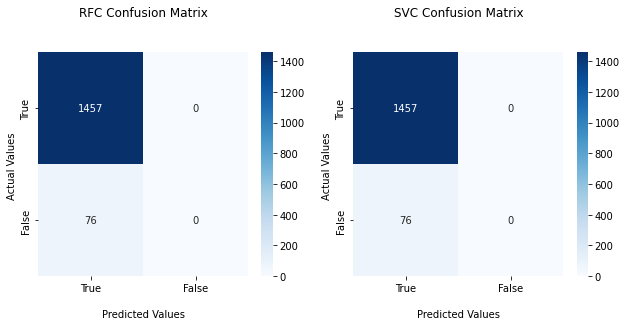

In [83]:
# lets see the confusion matrix using the best classifier's best estimator 
y_pred1 = best_classifier1.best_estimator_.predict(val_X)
y_pred2 = best_classifier2.best_estimator_.predict(val_X)

# heat map using sns and scikitlearn's confusion_matrix function
plt.figure(figsize=(16, 14))
plt.subplot(3, 3, 1)
ax1 = sns.heatmap(confusion_matrix(val_y, y_pred1), annot=True, fmt='', cmap='Blues')
plt.subplot(3, 3, 2)
ax2 = sns.heatmap(confusion_matrix(val_y, y_pred2), annot=True, fmt='', cmap='Blues')

ax1.set_title('RFC Confusion Matrix\n\n');
ax1.set_xlabel('\nPredicted Values')
ax1.set_ylabel('Actual Values ');

ax2.set_title('SVC Confusion Matrix\n\n');
ax2.set_xlabel('\nPredicted Values')
ax2.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['True','False'])
ax1.yaxis.set_ticklabels(['True','False'])

ax2.xaxis.set_ticklabels(['True','False'])
ax2.yaxis.set_ticklabels(['True','False'])

## Display the visualization of the Confusion Matrix.
plt.show();

> In both the models, there are 
>  * 1457 true positives (predicted positive and it’s true) ,
>  * 0 true negatives (predicted negative and it’s true), 
>  * 0 false positives (predicted positive and it’s false) 
>  * and 76 false negatives (You predicted negative and it’s false)

Best Estimator Feature Importance

In [84]:
# get importance
feature_importance = best_classifier2.best_estimator_.coef_[0]
len(feature_importance)

19

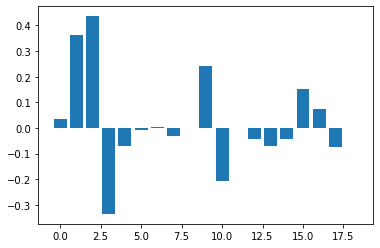

In [85]:
# plot feature importance
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.show();

>  Notice that the coefficients are both positive and negative. We have a total of 19 features and the positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0. No clear pattern of important and unimportant features can be identified from the above visualization

## Conclusion
<a class="anchor" id="conclude"></a>

In conclusion, we used the Stroke Prediction data set from kaggle,
* after loading and cleaning the data, 
* we explored the dataset to see the risk ratio , mutual info , corelation of various feature to the target variable. 
* we also prepared the data along the way, by converting datatypes to more suitable types, imputing values, and applying One-Hot encoding. 
* We then looked at various estimators to solve the binary classification problem, Random Forest and Support Vector Machine both gave the best accuracy among all the estimators we chose. 
* We tuned the model and achieved an accuracy of 95% for both Random Forest and Support Vector Classifier. 

We could also increase the accuracy by testing the data with other estimators (like K-Nearest Neighbor) and use only specific features that are more important than others. 

References

https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset</br>
https://www.simplilearn.com/10-algorithms-machine-learning-engineers-need-to-know-article </br>
https://www.simplilearn.com/tutorials/machine-learning-tutorial/random-forest-algorithm</br>
https://scikit-learn.org/stable/modules/svm.html</br>
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html </br>
https://scikit-learn.org/stable/modules/preprocessing.html </br>
https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression</br>
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/ </br>
https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/ </br>
https://machinelearningmastery.com/calculate-feature-importance-with-python/ </br>
https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/#:~:text=Plot%20Confusion%20Matrix%20for%20Binary%20Classes%20With%20Labels&text=You%20need%20to%20create%20a,matrix%20with%20the%20labels%20annotation </br>
https://stackoverflow.com/questions/31511997/pandas-dataframe-replace-all-values-in-a-column-based-on-condition </br>
https://www.delftstack.com/howto/python/python-get-class-name/ </br>

    